<a href="https://colab.research.google.com/github/chethana-dissanayka/Emotion_Detection_Model/blob/master/Emotion_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link with Kaggle

In [4]:
! pip install kaggle

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets list

ref                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                Netflix Movies and TV Shows                           1MB  2024-04-10 09:48:38           3837         75  1.0              
mexwell/heart-disease-dataset                         🫀 Heart Disease Dataset                             399KB  2024-04-08 09:43:49           2054         36  1.0              
asaniczka/university-employee-salaries-2011-present   University Employee Salaries (2011 - Present)        17MB  2024-04-07 10:11:15           1657         45  1.0              
fatemehmehrparvar/obesity-levels                      Obesity Levels                                       58K

In [10]:
! kaggle datasets download 'jonathanoheix/face-expression-recognition-dataset'

face-expression-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
! unzip face-expression-recognition-dataset.zip

Archive:  face-expression-recognition-dataset.zip
replace images/images/train/angry/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop

In [13]:
folder_path = "images/"

In [14]:
BATCH_SIZE = 128
IMAGE_SIZE = 48
# CHANNELS=3
# EPOCHS=50
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 28821 files belonging to 7 classes.


In [15]:
class_names = train_dataset.class_names
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [16]:
# Get the number of classes (unique target labels)
num_classes = len(set(train_dataset.class_names))

# Print the number of classes
print("Number of classes:", num_classes)

Number of classes: 7


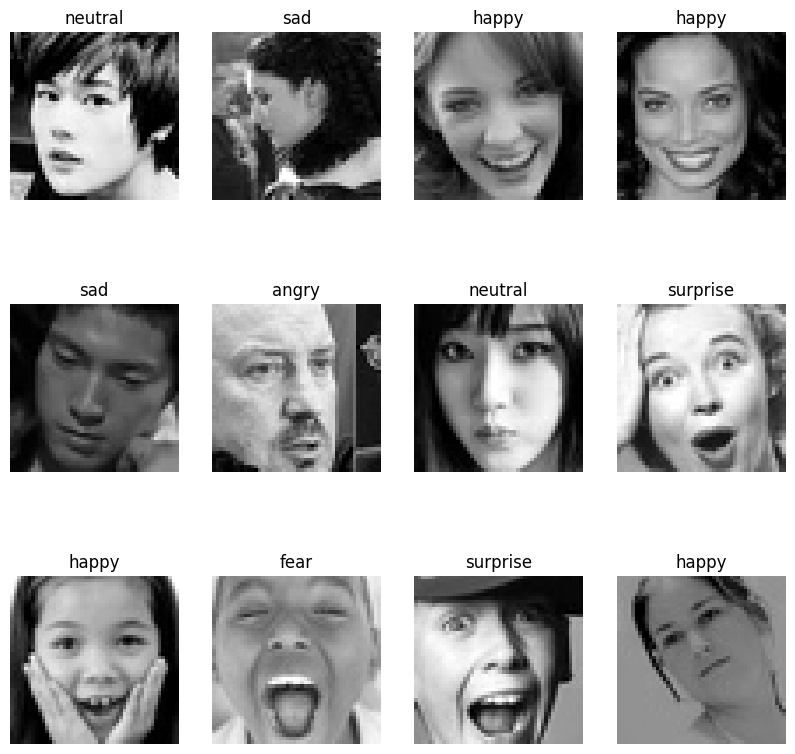

In [17]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

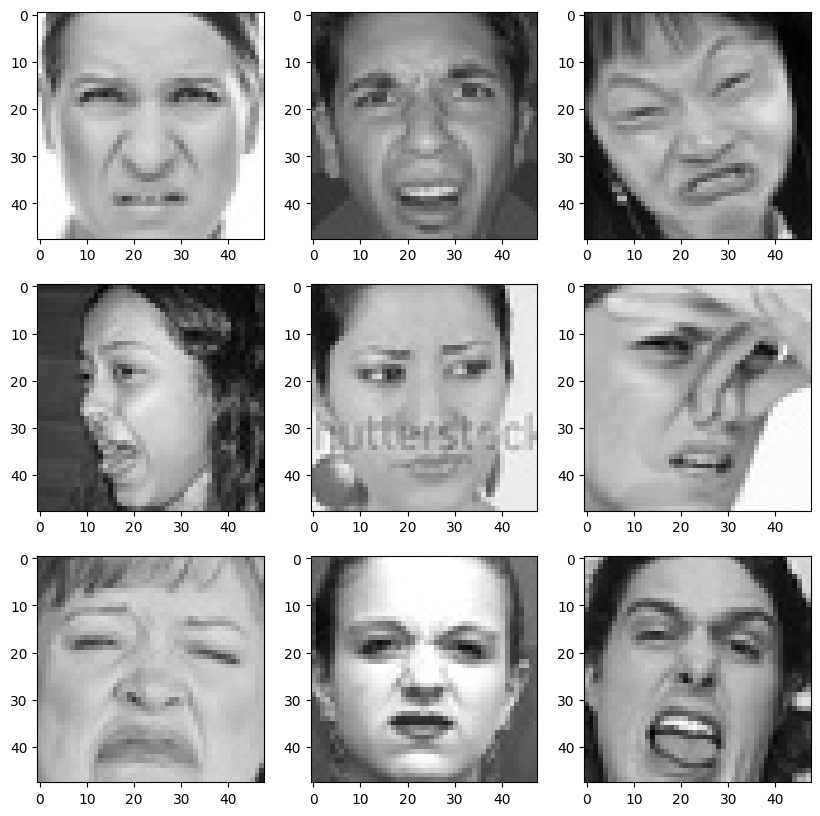

In [18]:
expression = 'disgust'

plt.figure(figsize= (10,10))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(IMAGE_SIZE, IMAGE_SIZE))
    plt.imshow(img)
plt.show()

In [19]:
datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                              color_mode = "grayscale",
                                              batch_size=BATCH_SIZE,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                              color_mode = "grayscale",
                                              batch_size=BATCH_SIZE,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [20]:
from keras.optimizers import Adam,SGD,RMSprop

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization()) # improve training stability by normalizing the activations of the previous layer.
model.add(Activation('relu')) # non-linearity
model.add(MaxPooling2D(pool_size = (2,2))) # reduce dimensionality --> Max pooling --> Maximum Value
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same')) # extract features from the images
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2))) # downsampling by taking the maximum value from a 2x2 grid of pixels
model.add(Dropout (0.25)) #  randomly drops 25% of the activations during training, helping prevent overfitting.

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same')) # Number of filters (e.g., 64, 128, etc.): This specifies the number of feature maps the layer will learn.

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same')) # Kernel size (e.g., (3,3), (5,5)): This defines the size of the filter used for convolution.
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) # flattens the output of the convolutional layers into a 1D vector suitable for feeding into fully connected layers.

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes, activation='softmax'))



opt = Adam(learning_rate=  0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [21]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 48

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_set,
                    steps_per_epoch=train_set.n // train_set.batch_size,
                    epochs=epochs,
                    validation_data=test_set,
                    validation_steps=test_set.n // test_set.batch_size,
                    callbacks=callbacks_list)

Epoch 1/48
111/225 [=============>................] - ETA: 12:42 - loss: 1.9640 - accuracy: 0.2437